In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Execution calculation start here and 
import time
startTime=time.time()

# Install the findspark here
!pip install findspark

In [3]:
# Import the findspark and initialize here 
import findspark 
findspark.init("C:\spark")

In [4]:
# Import the necessary library and start the SparkSession here 
import pyspark as ps 
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder 
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np
import seaborn as sns 

spark=SparkSession.builder\
    .master("local")\
    .appName("final")\
    .getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

sc

<SparkContext master=local appName=final>

In [5]:
# host name and ip address 
import socket 
def get_Host_name_IP():
    try:
        host_name = socket.gethostname()
        host_ip = socket.gethostbyname(host_name)
        print("Hostname :  ", host_name)
        print("IP : ", host_ip)
    except:
        print("Unable to get Hostname and IP")

get_Host_name_IP()

Hostname :   DESKTOP-VAJEO53
IP :  192.168.1.42


In [6]:
df_ratings=spark.read.csv("data/ratings.csv" , header=True , inferSchema=True)
df_ratings.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [7]:
df_ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ratings.columns]
   ).show()

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



In [8]:
df_ratings.show(5)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



In [9]:
df_ratings.count()

981756

In [10]:
df_books=spark.read.csv("data/books.csv" , header=True , inferSchema=True)
df_books.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


In [11]:
df_books.show(1)

+---+-------+------------+-------+-----------+---------+----------------+---------------+-------------------------+----------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|        authors|original_publication_year|  original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+---------------+-------------------------+----------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
|  1

In [12]:
traning_df , validation_df = df_ratings.randomSplit([0.7 , 0.3])

In [13]:
traning_df.count()

687283

In [14]:
validation_df.count()

294473

In [15]:
als=ALS(
        userCol="user_id" , 
        itemCol="book_id" ,
        ratingCol="rating" 
       )
model=als.fit(traning_df)
predicts=model.transform(validation_df)
new_predicts=predicts.filter(col("prediction") != np.nan)
evaluator=RegressionEvaluator(metricName="rmse" , labelCol="rating" , predictionCol="prediction")
rmse=evaluator.evaluate(new_predicts)
print("Root Mean Square Value  ===> " + str(rmse))

Root Mean Square Value  ===> 0.9275607705516028


In [16]:
df_train=traning_df.toPandas()

<AxesSubplot:>

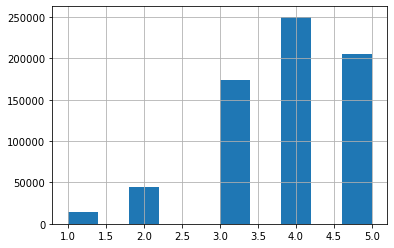

In [17]:
df_train['rating'].hist()

<AxesSubplot:xlabel='rating', ylabel='count'>

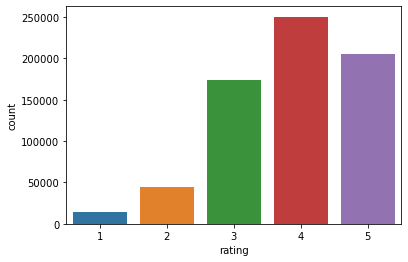

In [18]:
sns.countplot(df_train['rating'])

In [19]:
df_valide=validation_df.toPandas()

<AxesSubplot:>

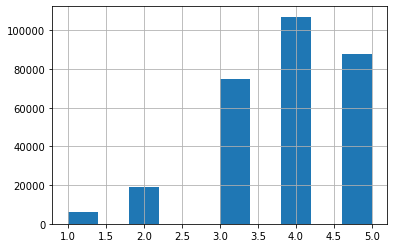

In [20]:
df_valide["rating"].hist()

<AxesSubplot:xlabel='rating', ylabel='count'>

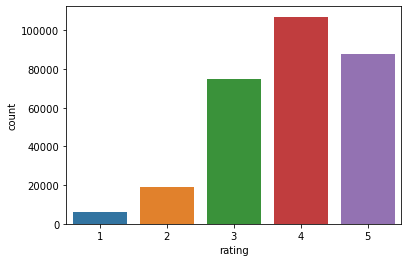

In [21]:
sns.countplot(df_valide["rating"])

In [77]:
iterations=10    #Default value
regularization_paramater=0.1
rank=4

In [78]:
als1=ALS(maxIter=iterations ,
        regParam=regularization_paramater ,
        rank=4 , 
        userCol="user_id" , 
        itemCol="book_id" ,
        ratingCol="rating" 
       )
model=als1.fit(traning_df)
predicts=model.transform(validation_df)
new_predicts=predicts.filter(col("prediction") != np.nan)
evaluator=RegressionEvaluator(metricName="rmse" , labelCol="rating" , predictionCol="prediction")
rmse=evaluator.evaluate(new_predicts)
print("Root Mean Square Value  ===> " + str(rmse))

Root Mean Square Value  ===> 0.9097206255794003


In [ ]:
als2=ALS(maxIter=iterations ,
        regParam=regularization_paramater ,
        rank=5, 
        userCol="user_id" , 
        itemCol="book_id" ,
        ratingCol="rating" 
       )
model=als2.fit(traning_df)
predicts=model.transform(validation_df)
new_predicts=predicts.filter(col("prediction") != np.nan)
evaluator=RegressionEvaluator(metricName="rmse" , labelCol="rating" , predictionCol="prediction")
rmse=evaluator.evaluate(new_predicts)
print("Root Mean Square Value  ===> " + str(rmse))

In [48]:
for rank in [10,50,200]:
    als3=ALS(maxIter=iterations ,
        regParam=regularization_paramater ,
        rank=rank , 
        userCol="user_id" , 
        itemCol="book_id" ,
        ratingCol="rating" 
       )
    model=als3.fit(traning_df)
    predicts=model.transform(validation_df)
    new_predicts=predicts.filter(col("prediction") != np.nan)
    evaluator=RegressionEvaluator(metricName="rmse" , labelCol="rating" , predictionCol="prediction")
    rmse=evaluator.evaluate(new_predicts)
    print("Rank" ,rank , "Root Me an Square Value  ===> " + str(rmse))
    

Rank 10 Root Me an Square Value  ===> 0.9234879371383912
Rank 50 Root Me an Square Value  ===> 0.9005091657700605
Rank 200 Root Me an Square Value  ===> 0.886554605457666


In [ ]:
for seed in [5,0,1,8]:
    als4=ALS(maxIter=iterations ,
        regParam=regularization_paramater ,
        rank=200 , 
        seed=seed,
        userCol="user_id" , 
        itemCol="book_id" ,
        ratingCol="rating" 
       )
    model=als4.fit(traning_df) 
    predicts=model.transform(validation_df)
    new_predicts=predicts.filter(col("prediction") != np.nan)
    evaluator=RegressionEvaluator(metricName="rmse" , labelCol="rating" , predictionCol="prediction")
    rmse=evaluator.evaluate(new_predicts)
    print("Rank" ,seed , "Root Me an Square Value  ===> " + str(rmse))
    

In [71]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

In [72]:
data=df_ratings.toPandas()
data.head(3)

X=data.drop( columns="rating" , axis=1)
Y=data["rating"]

x_train,x_test,y_train,y_test=train_test_split(X , Y , test_size=0.3, random_state=33)

In [74]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(687229, 2) (294527, 2) (687229,) (294527,)


In [80]:

rf_params = {'seed': [5,0,1,8],
    'rank': [10,50,200],
    'iteration': [10,50,200],
    'lambda': [0.01,0.1],
    }

als_gridcv_model = GridSearchCV(estimator=als , param_grid=rf_params , cv=5,scoring='accuracy', n_jobs=-1, verbose=2).fit(x_train,y_train)

print('rf gridcv model accuracy score = {}'.format(als_gridcv_model.best_params_))

TypeError: Cannot clone object 'ALS_7d968b851f8c' (type <class 'pyspark.ml.recommendation.ALS'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [22]:
prediction=model.transform(validation_df)
prediction.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|   1169|     4|  3.930167|
|      1|   5461|     3| 4.3513885|
|      1|  10140|     4| 3.4066544|
|      1|  10335|     4|  4.001644|
|      1|  10944|     5| 4.2720704|
|      1|  11854|     4|  4.080465|
|      1|  16377|     4|  4.693045|
|      1|  16913|     5| 4.3627496|
|      1|  18031|     5| 4.9047494|
|      1|  18313|     5| 4.9561167|
+-------+-------+------+----------+
only showing top 10 rows



In [23]:
df_predict=prediction.toPandas()

In [24]:
df_predict.head()

,book_id,user_id,rating,prediction
0,2,32592,4,4.184015
1,3,32592,5,3.553391
2,6,35982,2,3.782817
3,7,19984,5,4.974205
4,8,32592,4,3.253865


<AxesSubplot:>

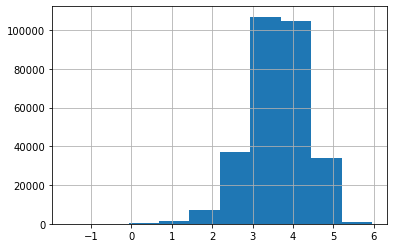

In [25]:
df_predict["prediction"].hist()

In [26]:
#sns.countplot(df_predict["prediction"])

In [35]:
prediction.join(df_books, "book_id").select("user_id","title","prediction").show(n=5)

+-------+--------------------+----------+
|user_id|               title|prediction|
+-------+--------------------+----------+
|  32592|Harry Potter and ...| 4.1840153|
|  32592|Harry Potter and ...|  3.553391|
|  35982|Harry Potter and ...| 3.7828174|
|  32592|Harry Potter Boxe...| 3.2538655|
|  32592|I'm a Stranger He...|  4.324193|
+-------+--------------------+----------+
only showing top 5 rows



In [28]:
one_user_predict=prediction.filter(col("user_id")==35982).join(df_books , "book_id").select("user_id","title","image_url","prediction")
one_user_predict.show()

+-------+--------------------+--------------------+----------+
|user_id|               title|           image_url|prediction|
+-------+--------------------+--------------------+----------+
|  35982|The Language Inst...|https://s.gr-asse...|  3.297205|
|  35982|The Door Into Summer|https://images.gr...| 3.0120835|
|  35982|Harry Potter and ...|https://images.gr...| 3.7828174|
|  35982|The Portrait of a...|https://images.gr...| 3.5012176|
+-------+--------------------+--------------------+----------+



In [29]:
for book in one_user_predict.take(10):
    print(book.title)
    print(book.image_url)
    print("*******************************************************************************************************")

The Language Instinct: How the Mind Creates Language
https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png
*******************************************************************************************************
The Door Into Summer
https://images.gr-assets.com/books/1342241886m/348.jpg
*******************************************************************************************************
Harry Potter and the Goblet of Fire (Harry Potter, #4)
https://images.gr-assets.com/books/1361482611m/6.jpg
*******************************************************************************************************
The Portrait of a Lady
https://images.gr-assets.com/books/1502148606m/264.jpg
*******************************************************************************************************


In [30]:
userRecommnet=model.recommendForAllUsers(10)
bookRecomment=model.recommendForAllItems(10)

userRecommnet.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------------------------------------+
|user_id|book_id                                                     |
+-------+------------------------------------------------------------+
|1      |[9842, 6920, 721, 862, 5207, 4708, 6590, 5580, 1788, 7081]  |
|2      |[9260, 5333, 8200, 5252, 4352, 8035, 9842, 3243, 7417, 9320]|
|4      |[7373, 4497, 7569, 9050, 5349, 8703, 4850, 7716, 9552, 7327]|
|5      |[9842, 4708, 8913, 7988, 862, 6590, 2001, 9076, 9569, 1471] |
|6      |[4256, 8362, 3692, 6932, 3491, 9006, 1047, 6751, 5376, 2590]|
|7      |[7401, 8818, 1380, 983, 3457, 3491, 3628, 568, 1851, 7440]  |
|8      |[5554, 6558, 2439, 103, 6378, 85, 5344, 896, 1908, 3736]    |
|9      |[3248, 6876, 9842, 6920, 8831, 4336, 2958, 5207, 6591, 3746]|
|10     |[4653, 5492, 7440, 4622, 8831, 3206, 1462, 2648, 4, 4301]   |
|11     |[2590, 6659, 3885, 9032, 7629, 3920, 6927, 9076, 3368, 4464]|
+-------+------------------------------------------------------------+
only s

In [31]:
userRecommnet.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [32]:
bookRecomment.select("book_id","recommendations.user_id").show(10,False)

+-------+----------------------------------------------------------------------+
|book_id|user_id                                                               |
+-------+----------------------------------------------------------------------+
|1      |[50307, 15449, 1203, 24127, 5527, 26446, 35888, 41862, 26605, 20111]  |
|2      |[30757, 41862, 50769, 50505, 28724, 50307, 5527, 1203, 11296, 51341]  |
|3      |[50307, 29054, 18189, 28724, 50981, 34886, 17003, 23180, 20124, 43127]|
|4      |[6539, 30699, 30446, 50505, 2613, 26605, 50307, 32556, 1203, 36162]   |
|5      |[50307, 10923, 24313, 50333, 36162, 9958, 52743, 40790, 36476, 39253] |
|6      |[50307, 1203, 42821, 34879, 50192, 9958, 22044, 30126, 49974, 32556]  |
|7      |[50307, 41819, 40911, 50124, 15449, 20715, 32647, 30525, 27951, 24388]|
|8      |[50333, 36162, 51341, 50307, 24313, 24127, 15449, 39253, 38168, 43150]|
|9      |[51193, 18189, 50624, 32731, 32444, 20992, 11548, 37073, 7817, 27801] |
|10     |[44715, 50307, 5050

In [33]:
bookRecomment.printSchema()

root
 |-- book_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- user_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
print(endTime-startTime)